<a href="https://colab.research.google.com/github/aboagyeso/ML_Xgboost/blob/master/Copy_xgboost__Kinase_Regression_P15056.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT PACKAGES

In [0]:
import numpy as np
import sklearn.metrics, math
from sklearn.linear_model import LinearRegression  
from xgboost import XGBRegressor 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
# Set random seed
np.random.seed(0)

In [0]:

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
#from xgboost import XGBRegressor

DEFINE CUSTOM FUNCTIONS

In [0]:


# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

In [0]:

def add_gausian(y,mu,sigma):
    noise = np.random.normal(mu,sigma,[1526, 117])
    df_aug = df_train_set +noise 
    #df_new = pd.concat([df_train_set,df_aug])
    return(df_aug)

def drop_corr(df):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column]>0.95)]
    df_new = df.drop(df[to_drop],axis = 1)
    return(df_new)

def model_eval(model):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    #model_score = model.score(X_test,y_test)
    model_mse =  mse(y_test,pred)
    model_r2 =r2(y_test,pred)
    return(-model_mse, model_r2)

In [0]:
# Load libraries
from keras import models
from keras import layers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

In [0]:

# imports
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

READ IN THE DATAFRAME AND CHECK OUTPUT

In [143]:
df = pd.read_csv('https://raw.githubusercontent.com/aboagyeso/Kinase_activity/master/data/kinase_files/KinaseP15056.csv')
df.head()

,Unnamed: 0,target_id,pAc,smiles,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,NumHeteroAtoms,NumHeavyAtoms,NumAtoms,NumStereocenters,NumUnspecifiedStereocenters,NumRings,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3,Chi0v,Chi1v,Chi2v,Chi3v,Chi4v,Chi1n,Chi2n,Chi3n,...,MQN2,MQN3,MQN4,MQN5,MQN6,MQN7,MQN8,MQN9,MQN10,MQN11,MQN12,MQN13,MQN14,MQN15,MQN16,MQN17,MQN19,MQN20,MQN21,MQN22,MQN23,MQN24,MQN25,MQN26,MQN27,MQN28,MQN29,MQN30,MQN31,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,11345,P15056,4.04,COC(CNS(=O)(=O)C1=CC2=C(C=C1)NC3=C2C=CN=C3C(=O...,0.71220,95.1121,149.087392,136.40,378.410,378.099791,9,4,7,3,6,1,10,26,44,0,0,3,3,0,0,2,0,0,1,0,0,0.250000,14.961759,9.109095,7.298575,5.422592,3.722947,7.625932,5.531622,4.001349,...,0,0,0,0,1,0,2,2,5,0,26,10,3,0,8,7,7,14,9,4,3,0,0,6,4,2,1,7,6,0,0,0,1,2,0,0,0,0,4,2
1,11346,P15056,4.13,CC(=O)NC1=CC=CC(=C1)C2=CN=CC(=N2)NC3=CC=CC=C3OC,3.85420,98.0484,145.454506,76.14,334.379,334.142976,6,2,5,2,5,1,6,25,43,0,0,3,3,0,0,1,0,0,2,0,0,0.105263,13.984426,7.756176,5.376829,3.482963,2.410711,7.756176,5.376829,3.482963,...,0,0,0,0,0,0,2,2,2,0,25,8,1,0,9,9,5,8,6,2,2,0,0,3,3,1,0,12,6,0,0,0,0,3,0,0,0,0,0,0
2,11347,P15056,4.23,CC(=O)NS(=O)(=O)C1=CC2=C(C=C1)NC3=C2C=CN=C3,1.54090,74.6022,114.425585,91.92,289.316,289.052112,6,2,2,2,4,1,7,20,31,0,0,3,3,0,0,2,0,0,1,0,0,0.076923,11.360805,7.343984,6.097736,4.390734,3.161004,5.860821,4.415334,2.960011,...,0,0,0,0,1,0,1,2,3,0,20,4,3,0,8,7,2,9,6,2,2,0,0,4,1,1,1,8,5,0,0,0,1,2,0,0,0,0,4,2
3,11348,P15056,4.24,CC1=CC(=NN1C2=NC3=C(N2CC4=CC=CC=C4)C(=O)N(C(=O...,1.28454,102.3550,154.480263,79.64,364.409,364.164774,8,0,3,0,8,0,8,27,47,0,0,4,4,0,0,3,0,0,1,0,0,0.263158,15.670987,8.620165,6.700425,4.710375,3.343836,8.620165,6.700425,4.710375,...,0,0,0,0,0,0,0,6,2,0,27,7,2,0,11,10,3,10,8,0,0,0,0,6,1,0,0,8,12,0,0,0,2,2,0,0,0,0,2,1
4,11349,P15056,4.24,CN1C2=C(C(=O)NC1=O)N(C(=N2)N/N=C\C3=CC=C(C=C3)...,1.82580,115.4518,174.001470,140.21,419.401,419.134202,11,2,6,2,9,0,11,31,48,0,0,4,4,0,0,2,0,0,2,0,0,0.100000,16.349671,9.208171,6.716305,4.672664,3.086504,9.208171,6.716305,4.672664,...,0,0,0,0,0,0,3,4,4,0,31,8,4,0,11,11,6,16,11,2,2,1,1,5,4,1,0,11,10,0,0,0,1,3,0,0,0,0,2,1


In [144]:
#Check the shape of the dataframe
df.shape

(1696, 120)

In [145]:
#Drop the highly correlated features
drop_corr(df).head()

,Unnamed: 0,target_id,smiles,SlogP,SMR,TPSA,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,NumHeteroAtoms,NumStereocenters,NumUnspecifiedStereocenters,NumRings,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3,Chi3v,HallKierAlpha,slogp_VSA1,slogp_VSA2,slogp_VSA3,slogp_VSA4,slogp_VSA5,slogp_VSA6,slogp_VSA7,slogp_VSA8,slogp_VSA10,slogp_VSA11,slogp_VSA12,smr_VSA1,...,peoe_VSA7,peoe_VSA8,peoe_VSA9,peoe_VSA10,peoe_VSA11,peoe_VSA12,peoe_VSA13,peoe_VSA14,MQN2,MQN4,MQN5,MQN6,MQN7,MQN8,MQN9,MQN10,MQN11,MQN13,MQN14,MQN15,MQN16,MQN20,MQN24,MQN25,MQN26,MQN27,MQN28,MQN29,MQN30,MQN31,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41
0,11345,P15056,COC(CNS(=O)(=O)C1=CC2=C(C=C1)NC3=C2C=CN=C3C(=O...,0.71220,95.1121,136.40,9,4,7,3,6,1,10,0,0,3,3,0,0,2,0,0,1,0,0,0.250000,5.422592,-2.53,10.455762,51.347312,19.497017,0.000000,10.488465,35.357795,0.0,21.805850,0.000000,0.000000,0.0,22.686060,...,24.265468,36.705588,16.956941,0.000000,11.983955,10.023291,5.907180,0.000000,0,0,0,1,0,2,2,5,0,10,3,0,8,14,0,0,6,4,2,1,7,6,0,0,0,1,2,0,0,0,0,4
1,11346,P15056,CC(=O)NC1=CC=CC(=C1)C2=CN=CC(=N2)NC3=CC=CC=C3OC,3.85420,98.0484,76.14,6,2,5,2,5,1,6,0,0,3,3,0,0,1,0,0,2,0,0,0.105263,3.482963,-3.41,15.370440,22.984934,4.794537,0.000000,6.923737,60.924624,0.0,11.257379,17.192635,5.749512,0.0,9.531400,...,24.265468,18.174575,30.884799,11.567375,0.000000,5.907180,0.000000,0.000000,0,0,0,0,0,2,2,2,0,8,1,0,9,8,0,0,3,3,1,0,12,6,0,0,0,0,3,0,0,0,0,0
2,11347,P15056,CC(=O)NS(=O)(=O)C1=CC2=C(C=C1)NC3=C2C=CN=C3,1.54090,74.6022,91.92,6,2,2,2,4,1,7,0,0,3,3,0,0,2,0,0,1,0,0,0.076923,4.390734,-2.41,4.722095,24.292934,14.817828,0.000000,6.923737,41.554639,0.0,21.805850,0.000000,0.000000,0.0,13.212334,...,24.265468,29.409730,16.609028,0.000000,0.000000,5.907180,10.023291,0.000000,0,0,0,1,0,1,2,3,0,4,3,0,8,9,0,0,4,1,1,1,8,5,0,0,0,1,2,0,0,0,0,4
3,11348,P15056,CC1=CC(=NN1C2=NC3=C(N2CC4=CC=CC=C4)C(=O)N(C(=O...,1.28454,102.3550,79.64,8,0,3,0,8,0,8,0,0,4,4,0,0,3,0,0,1,0,0,0.263158,4.710375,-3.42,11.249010,28.465762,20.640100,13.847474,16.951307,45.987277,0.0,17.112217,0.000000,0.000000,0.0,0.000000,...,25.477293,19.789272,12.238684,0.000000,11.163878,5.948339,5.559267,5.689743,0,0,0,0,0,0,6,2,0,7,2,0,11,10,0,0,6,1,0,0,8,12,0,0,0,2,2,0,0,0,0,2
4,11349,P15056,CN1C2=C(C(=O)NC1=O)N(C(=N2)N/N=C\C3=CC=C(C=C3)...,1.82580,115.4518,140.21,11,2,6,2,9,0,11,0,0,4,4,0,0,2,0,0,2,0,0,0.100000,4.672664,-4.54,16.674802,30.240068,13.592428,10.114318,11.126903,69.287786,0.0,11.163878,11.635726,0.000000,0.0,4.923311,...,23.259637,19.180406,17.682668,0.000000,11.163878,5.948339,11.246653,5.689743,0,0,0,0,0,3,4,4,0,8,4,0,11,16,1,1,5,4,1,0,11,10,0,0,0,1,3,0,0,0,0,2


In [146]:
drop_corr(df).shape

(1696, 94)

In [0]:
#Plot distribution of the pAc with the density estimation function
#f, ax = plt.subplots(figsize=(6, 6))
#sns.distplot(df.pAc,color = 'green');
#sns.set_style("whitegrid")

In [0]:
#Boxplot of pAc,It has a few outliers but the distribution in fairly normal
#f, ax = plt.subplots(figsize=(5, 6))
#sns.set_style("whitegrid")
#data = df.pAc
#sns.boxplot(data=data);

In [149]:
#Drop unwanted columns
df = df.drop(['Unnamed: 0','smiles','target_id'], axis=1)
df.head()

,pAc,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,NumHeteroAtoms,NumHeavyAtoms,NumAtoms,NumStereocenters,NumUnspecifiedStereocenters,NumRings,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3,Chi0v,Chi1v,Chi2v,Chi3v,Chi4v,Chi1n,Chi2n,Chi3n,Chi4n,HallKierAlpha,kappa1,...,MQN2,MQN3,MQN4,MQN5,MQN6,MQN7,MQN8,MQN9,MQN10,MQN11,MQN12,MQN13,MQN14,MQN15,MQN16,MQN17,MQN19,MQN20,MQN21,MQN22,MQN23,MQN24,MQN25,MQN26,MQN27,MQN28,MQN29,MQN30,MQN31,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,4.04,0.71220,95.1121,149.087392,136.40,378.410,378.099791,9,4,7,3,6,1,10,26,44,0,0,3,3,0,0,2,0,0,1,0,0,0.250000,14.961759,9.109095,7.298575,5.422592,3.722947,7.625932,5.531622,4.001349,2.680586,-2.53,18.266753,...,0,0,0,0,1,0,2,2,5,0,26,10,3,0,8,7,7,14,9,4,3,0,0,6,4,2,1,7,6,0,0,0,1,2,0,0,0,0,4,2
1,4.13,3.85420,98.0484,145.454506,76.14,334.379,334.142976,6,2,5,2,5,1,6,25,43,0,0,3,3,0,0,1,0,0,2,0,0,0.105263,13.984426,7.756176,5.376829,3.482963,2.410711,7.756176,5.376829,3.482963,2.410711,-3.41,16.447862,...,0,0,0,0,0,0,2,2,2,0,25,8,1,0,9,9,5,8,6,2,2,0,0,3,3,1,0,12,6,0,0,0,0,3,0,0,0,0,0,0
2,4.23,1.54090,74.6022,114.425585,91.92,289.316,289.052112,6,2,2,2,4,1,7,20,31,0,0,3,3,0,0,2,0,0,1,0,0,0.076923,11.360805,7.343984,6.097736,4.390734,3.161004,5.860821,4.415334,2.960011,2.144520,-2.41,12.615072,...,0,0,0,0,1,0,1,2,3,0,20,4,3,0,8,7,2,9,6,2,2,0,0,4,1,1,1,8,5,0,0,0,1,2,0,0,0,0,4,2
3,4.24,1.28454,102.3550,154.480263,79.64,364.409,364.164774,8,0,3,0,8,0,8,27,47,0,0,4,4,0,0,3,0,0,1,0,0,0.263158,15.670987,8.620165,6.700425,4.710375,3.343836,8.620165,6.700425,4.710375,3.343836,-3.42,17.016950,...,0,0,0,0,0,0,0,6,2,0,27,7,2,0,11,10,3,10,8,0,0,0,0,6,1,0,0,8,12,0,0,0,2,2,0,0,0,0,2,1
4,4.24,1.82580,115.4518,174.001470,140.21,419.401,419.134202,11,2,6,2,9,0,11,31,48,0,0,4,4,0,0,2,0,0,2,0,0,0.100000,16.349671,9.208171,6.716305,4.672664,3.086504,9.208171,6.716305,4.672664,3.086504,-4.54,19.762467,...,0,0,0,0,0,0,3,4,4,0,31,8,4,0,11,11,6,16,11,2,2,1,1,5,4,1,0,11,10,0,0,0,1,3,0,0,0,0,2,1


In [0]:
# Get the feature vector
X = df.drop(columns=['pAc'],axis=1)
# Get the target vector
y = df["pAc"]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)

In [152]:
#Check the shape of the training and testing data 
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((1526, 116), (170, 116), (1526,), (170,))

 Add the X_train and y_train to form a a training set for augmentation
 **bold text**

In [153]:
df_train_set = pd.concat([X_train, y_train], axis = 1)
df_train_set.head()

,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,NumHeteroAtoms,NumHeavyAtoms,NumAtoms,NumStereocenters,NumUnspecifiedStereocenters,NumRings,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3,Chi0v,Chi1v,Chi2v,Chi3v,Chi4v,Chi1n,Chi2n,Chi3n,Chi4n,HallKierAlpha,kappa1,kappa2,...,MQN3,MQN4,MQN5,MQN6,MQN7,MQN8,MQN9,MQN10,MQN11,MQN12,MQN13,MQN14,MQN15,MQN16,MQN17,MQN19,MQN20,MQN21,MQN22,MQN23,MQN24,MQN25,MQN26,MQN27,MQN28,MQN29,MQN30,MQN31,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42,pAc
682,3.77710,144.9243,226.750510,134.42,553.549,553.216156,11,4,6,3,10,1,14,40,66,0,0,5,4,1,1,2,1,1,2,0,0,0.269231,21.658251,12.275290,9.191411,6.445773,4.248161,12.275290,9.191411,6.445773,4.248161,-4.72,26.869974,10.804161,...,0,0,0,0,0,3,6,2,0,40,14,1,0,18,11,6,13,11,4,3,0,0,7,3,1,1,16,12,0,0,0,0,5,0,0,0,0,2,1,7.460
1057,4.00460,136.7735,207.798560,109.14,499.600,499.179044,9,1,4,1,7,0,10,36,61,2,2,7,5,2,2,4,2,2,1,0,0,0.307692,20.558504,14.026577,11.735332,9.085085,7.801421,12.178265,9.847655,7.722898,6.335321,-3.63,21.636556,7.938926,...,0,0,0,1,0,0,7,2,0,36,5,2,0,22,13,4,11,9,1,1,0,0,3,0,0,1,19,13,0,0,0,3,4,0,0,0,0,7,4,8.310
1525,4.33872,129.6286,208.295520,126.84,510.480,510.173957,10,3,6,3,9,1,13,37,58,1,1,5,4,1,1,3,1,1,1,0,0,0.250000,19.503931,11.304097,8.390924,5.722006,3.735286,11.304097,8.390924,5.722006,3.735286,-4.39,24.310861,9.931316,...,0,0,0,0,0,3,5,1,1,37,12,1,0,17,11,6,12,10,3,3,0,0,5,3,1,1,17,10,0,0,0,1,4,0,0,0,0,2,1,9.000
518,4.90772,109.2753,165.813847,87.50,391.402,391.133220,6,3,4,3,6,0,7,29,47,0,0,4,4,0,0,1,0,0,3,0,0,0.090909,15.771220,8.842948,6.584373,4.687067,3.077623,8.842948,6.584373,4.687067,3.077623,-3.87,18.491310,7.273202,...,0,0,0,0,0,1,2,3,0,29,9,0,0,12,11,4,9,6,3,3,0,0,5,2,0,0,11,11,0,0,0,0,4,0,0,0,0,2,1,6.985
1345,5.28192,154.4609,240.505445,108.40,580.615,580.252207,10,2,7,2,9,1,13,42,73,0,0,5,4,1,1,2,1,1,2,0,0,0.344828,23.658251,13.436251,10.304734,7.203380,4.782628,13.436251,10.304734,7.203380,4.782628,-4.52,28.988901,11.763594,...,0,0,0,0,0,2,6,2,0,42,16,1,0,18,11,7,12,10,2,2,0,0,8,3,2,1,16,12,0,0,0,0,5,0,0,0,0,2,1,8.700


In [0]:
#Assign df0 to df_train_set
df0 = df_train_set

In [155]:
#The shape of the training set
df0.shape

(1526, 117)

DATA BEFORE AUGMENTATION

In [156]:
# Get the feature vector
X0 = df0.drop(columns=['pAc'],axis=1).values
# Get the target vector
y0 = df0["pAc"].values
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.3,random_state=42)
X0_train.shape,y0_train.shape,X0_test.shape,y0_test.shape

((1068, 116), (1068,), (458, 116), (458,))

VALIDATION SET FOR EXTERNAL VALIDATION

In [0]:
X_test_val = X_test.values
y_test_val = y_test.values

AUGMENTATION 0.1

In [0]:
#Add noise of 0.01 to the dataframe
noise = add_gausian(df0,0,0.1)
df1 = pd.concat([df0,noise])
df1.shape
# Get the feature vector
X1 = df1.drop(columns=['pAc'],axis=1).values
# Get the target vector
y1 = df1["pAc"].values

#Split data into training and testing set
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3,random_state=42)

AUGMENTATION 0.2

In [0]:
#Add noise of 0.02 to the dataframe
noise = add_gausian(df0,0,0.2)
df2=pd.concat([df1,noise])

# Get the feature vector
X2 = df2.drop(columns=['pAc'],axis=1).values
# Get the target vector
y2 = df2["pAc"].values
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3,random_state=42)

AUGMENTATION 0.3

In [0]:
#Add noise of 0.03 to the dataframe
noise3 = add_gausian(df0,0,0.3)

df3 = pd.concat([df2,noise3])
# Get the feature vector
#X = df.drop('smiles', 'mol', 'pAc', axis=1)
X3 = df3.drop(columns=['pAc'],axis=1).values
# Get the target vector
y3 = df3["pAc"].values
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3,random_state=42)

BUILD XGBOOST MODELS  MODELS


MODEL0

In [0]:
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}
xgb = XGBRegressor(nthread=-1) 
grid = GridSearchCV(xgb,params,cv=1)

In [162]:

#Train the model
model0=xgb.fit(X0_train, y0_train)



[18:13:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


MODEL 1

In [163]:

#Train the model
model1=xgb.fit(X1_train, y1_train) 

[18:13:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


MODEL 2

In [164]:

# fit model
model2 = xgb.fit(X2_train, y2_train)

[18:13:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


MODEL 3

In [165]:

# fit model
model3=xgb.fit(X3_train, y3_train)


[18:13:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


MODEL0 EVALUATION

In [166]:
pred0 =model0.predict(X0_test)
print('Model0 Evaluation on test set:')
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y0_test,pred0))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y0_test,pred0))
print("\n")
print('Model0 Evaluation on Validation set:')
valid_pred0= model0.predict(X_test_val)
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y_test_val,valid_pred0))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y_test_val,valid_pred0))


Model0 Evaluation on test set:
Mean squared error (MSE):       0.318901
R square (R^2):                 0.815483


Model0 Evaluation on Validation set:
Mean squared error (MSE):       0.503741
R square (R^2):                 0.690022


MODEL1 EVALUATION

In [167]:
pred1 =model1.predict(X1_test)
print('Model0 Evaluation on test set:')
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y1_test,pred1))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y1_test,pred1))
print("\n")
print('Model0 Evaluation on Validation set:')
valid_pred1= model1.predict(X_test_val)
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y_test_val,valid_pred1))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y_test_val,valid_pred1))

Model0 Evaluation on test set:
Mean squared error (MSE):       0.335926
R square (R^2):                 0.802115


Model0 Evaluation on Validation set:
Mean squared error (MSE):       0.503741
R square (R^2):                 0.690022


MODEL 2 EVALUATION

In [168]:
# Predict test set
print('Model2 Test:')
y2_pred = model2.predict(X2_test) 
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y2_test,y2_pred))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y2_test,y2_pred))
print("\n")
#Evaluate model2 on validation prediction
print('Model2 Validation:')
valid_pred2 = model2.predict(X_test_val)
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y_test_val,valid_pred2))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y_test_val,valid_pred2))



Model2 Test:
Mean squared error (MSE):       0.336087
R square (R^2):                 0.782035


Model2 Validation:
Mean squared error (MSE):       0.503741
R square (R^2):                 0.690022


MODEL 3 EVALUATION

In [169]:
# Predict test set
y3_pred = model3.predict(X3_test) 
print('Test Set:')
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y3_test,y3_pred))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y3_test,y3_pred))
print("\n")
#Evaluate model3 on validation prediction
print('Validation set:')
valid_pred3 = model3.predict(X_test_val)
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y_test_val,valid_pred3))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y_test_val,valid_pred3))

Test Set:
Mean squared error (MSE):       0.396664
R square (R^2):                 0.754537


Validation set:
Mean squared error (MSE):       0.503741
R square (R^2):                 0.690022


VISUALIZATION

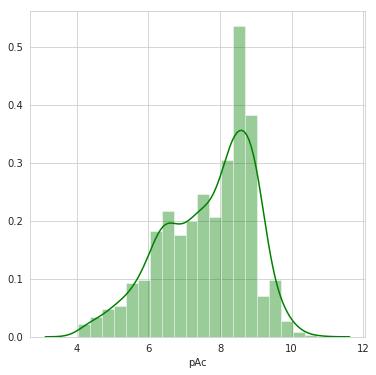

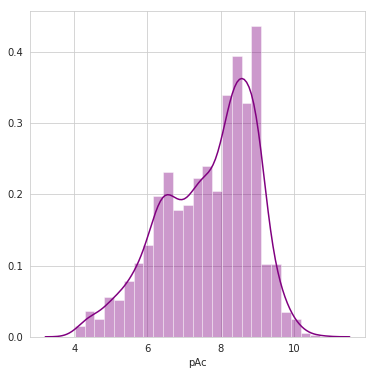

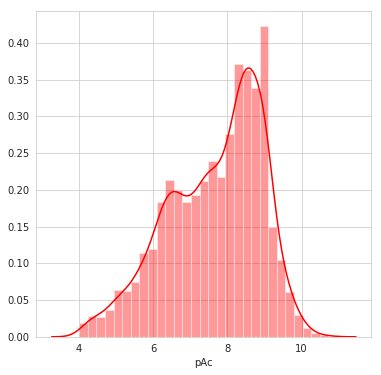

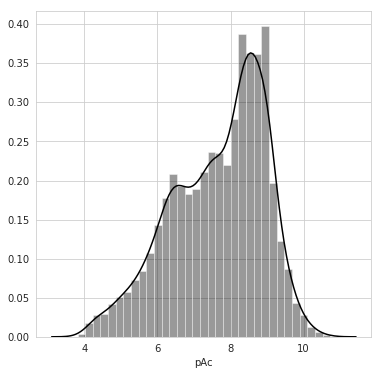

In [170]:

#Plot distribution of the pAc before augmentation and after each augmentation with the density estimation function
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(df0.pAc,color = 'green');
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(df1.pAc,color = 'purple');
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(df2.pAc,color = 'red');
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(df3.pAc,color = 'black');
sns.set_style("whitegrid")

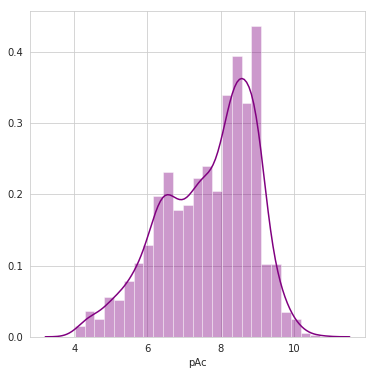

In [171]:

#Plot distribution of the pAc with the density estimation function after scaling
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(df1.pAc,color = 'purple');
sns.set_style("whitegrid")

VISUALIZE MODEL0 PREDICTION